# LAB 2

## Data preprocessing on Global Land Temperature

In [33]:
# !wget "https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/GLT_filtered.csv" -O GLT_filtered.csv

1. Load the Global Land Temperature dataset as a list of lists. Before starting, take a moment to better inspect the attributes you are going to work on. How many of them are nominal, how many
continuous or discrete?

In [34]:
import csv
import pandas as pd
import numpy as np

2. Analyze the attribute AverageTemperature, which contains missing values. Fill any gap with the arithmetic mean among the closest antecedent and the closest successive measurements in time, taken in the same city. Assume the following rules for edge cases:

a. it can happen that a missing value does not have a preceding (or successive) measurement. This happens when the missing value is the first (or last) value of the dataset. If this is the case, consider the missing value to be preceded (or followed) by a 0, then compute the mean accordingly

b. if there are consecutive missing values, just compute them in temporal order and use the newly inserted values to evaluate the following ones. Here it is an example with a simple list where both (a) and (b) rules have been applied

Definisco le funzioni per il calcolo delle medie di temperatura

In [35]:
def mean_calc_df_init(df):
    if np.isnan(df['AverageTemperature_filled']) and df['row_num'] == 1:
        return df['next_not_null_AvgTemp']/2
    else: 
        return df['AverageTemperature_filled']

def mean_calc_df_last(df):
    if np.isnan(df['AverageTemperature_filled']):
        return df['prev_not_null_AvgTemp']/2
    else: 
        return df['AverageTemperature_filled']

def mean_calc_df(df):
    if np.isnan(df['AverageTemperature_filled']):
        v = sum([2**i for i in range(0,df['consective_nones_pos'])])
        return (df['prev_not_null_AvgTemp'] + df['next_not_null_AvgTemp']*v)/(2**(df['consective_nones_pos']))
    else: 
        return df['AverageTemperature_filled']

Importo i dati

In [36]:
GLT_filtered = pd.read_csv('GLT_filtered.csv')

Trasformo il tipo di 'Date' in date e 'AverageTemperature' in valore numerico

In [37]:
GLT_filtered['Date'] = pd.to_datetime(GLT_filtered['Date'], format = '%Y-%m-%d')
GLT_filtered['AverageTemperature'] = pd.to_numeric(GLT_filtered['AverageTemperature']) 
# pd.to_numeric(GLT_filtered['AverageTemperature'], errors='coerce')

Creo la colonna che ospiterà le temperature medie senza NAN

In [38]:
GLT_filtered['AverageTemperature_filled'] = GLT_filtered['AverageTemperature']

Aggiungo il numero del record per ciascuna sezione relativa alle città

In [39]:
GLT_filtered['row_num'] = GLT_filtered\
    .groupby(['City'])\
    .cumcount()+1

Aggiungo colonna con prime temperature medie successive non NAN

In [40]:
GLT_filtered['next_not_null_AvgTemp'] = GLT_filtered['AverageTemperature_filled']
GLT_filtered['next_not_null_AvgTemp'] = GLT_filtered\
    .groupby(['City'])['next_not_null_AvgTemp']\
    .backfill()

Do il valore iniziale alla temperatura media nel caso in cui sia NAN nel primo record relativo a una città

In [41]:
GLT_filtered['AverageTemperature_filled'] = GLT_filtered.apply(mean_calc_df_init, axis=1)

Aggiungo colonna con prime temperature medie precedenti non NAN

In [42]:
GLT_filtered['prev_not_null_AvgTemp'] = GLT_filtered['AverageTemperature_filled']
GLT_filtered['prev_not_null_AvgTemp'] = GLT_filtered\
    .groupby(['City'])['prev_not_null_AvgTemp']\
    .ffill()


Aggiungo colonna con check valori nulli ({0,1}) in 'AverageTemperature_filled', colonna di appoggio con cumsum e colonna di appoggio con cumsum raggruppata su colonna precedente e su 'Città' 

In [43]:
GLT_filtered['avg_is_none'] = 0
GLT_filtered.loc[GLT_filtered['AverageTemperature_filled'].isnull(), 'avg_is_none'] = 1
GLT_filtered['consective_nones'] = (GLT_filtered['avg_is_none'] != GLT_filtered['avg_is_none'].shift(1)).cumsum()
GLT_filtered['consective_nones_pos'] = GLT_filtered\
    .groupby(['City','consective_nones'])['avg_is_none']\
    .cumsum()

Applico funzione per riempire i NAN

In [44]:
GLT_filtered['AverageTemperature_filled'] = GLT_filtered.apply(mean_calc_df, axis=1)

Applico funzione per eliminare i NAN rimanenti sugli ultimi record di ogni sezione 'Città'

In [45]:
GLT_filtered['AverageTemperature_filled'] = GLT_filtered.apply(mean_calc_df_last, axis=1)

Elimino colonne di appoggio

In [46]:
GLT_filtered = GLT_filtered.drop(['row_num', 'next_not_null_AvgTemp','prev_not_null_AvgTemp', 'avg_is_none', 'consective_nones','consective_nones_pos'], axis=1)

In [47]:
# a = GLT_filtered[GLT_filtered['AverageTemperature_filled'].isnull()]
# b = GLT_filtered.groupby('City').first()
# c = GLT_filtered.groupby('City').last()

2. Define a function that, given the name of a city and an integer N > 0, prints:  
    a. the top N hottest measurements;  
    b. the top N coldest measurements

In [48]:
def top_temperatures_city(df, name):
    df_out = df[df['City'] == name] 
    df_out_1 = df_out.nlargest(10,'AverageTemperature_filled')
    df_out_2 = df_out.nsmallest(10,'AverageTemperature_filled')
    return (df_out_1,df_out_2)
    # return(df_out)

In [49]:
highest,lowest = top_temperatures_city(df=GLT_filtered,name='Rome')
print(highest)
print(lowest)

             Date  AverageTemperature  AverageTemperatureUncertainty  City  \
173742 2003-08-01              25.951                          0.395  Rome   
173741 2003-07-01              24.998                          0.331  Rome   
173634 1994-08-01              24.873                          0.250  Rome   
173850 2012-08-01              24.731                          0.559  Rome   
173849 2012-07-01              24.480                          0.476  Rome   
173105 1950-07-01              24.380                          0.416  Rome   
173610 1992-08-01              24.294                          0.417  Rome   
172841 1928-07-01              24.252                          0.323  Rome   
173718 2001-08-01              24.210                          0.449  Rome   
173681 1998-07-01              24.169                          0.238  Rome   

       Country Latitude Longitude  AverageTemperature_filled  
173742   Italy   42.59N    13.09E                     25.951  
173741   Italy 

4. Let’s search for other anomalies in data distribution with the help of matplotlib. Plot the distri-
bution of the average land temperatures for Rome and Bangkok using the aforementioned histogram
plotting function.

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

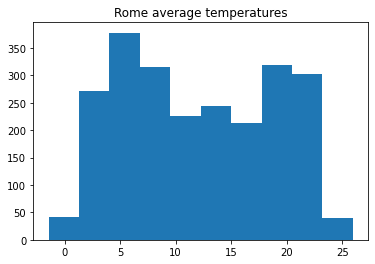

In [51]:
plt.hist(GLT_filtered[GLT_filtered['City'] == 'Rome'].filter(['AverageTemperature_filled']))
plt.title('Rome average temperatures')
plt.show()

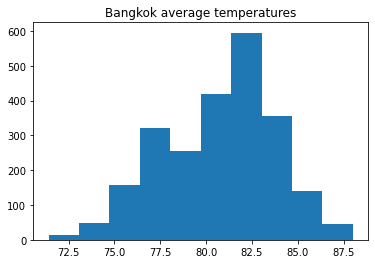

In [52]:
plt.hist(GLT_filtered[GLT_filtered['City'] == 'Bangkok'].filter(['AverageTemperature_filled']))
plt.title('Bangkok average temperatures')
plt.show()

5. One might think that Bangkok sensor provide temperature samples in degrees Fahrenheit while the ones located in Rome use the Celsius notation, which is the common representation in the whole dataset. Write a function to transform Fahrenheit measurements back to Celsius, apply it to your data and plot the two distribution again.

In [53]:
def fahrenheit_to_celsius(value):
    return (value - 32) / 1.8

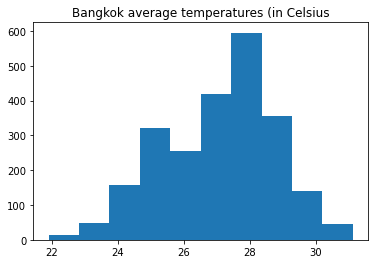

In [54]:
plt.hist(GLT_filtered[GLT_filtered['City'] == 'Bangkok']['AverageTemperature_filled'].transform(fahrenheit_to_celsius))
plt.title('Bangkok average temperatures (in Celsius')
plt.show()

## Textual data preparation on IMDB reviews

1. Load the IMDb dataset as a list of lists

In [55]:
aclimdb_reviews_train = []
with open('aclimdb_reviews_train.txt', encoding="utf8") as f:
    for row in f:
        aclimdb_reviews_train.append(row)
aclimdb_reviews_train = aclimdb_reviews_train[1:]

2. Apply the tokenization function listed below to your reviews. Please refer to the function’s docstring 1 for the input and output parameters. The tokenization procedure splits each comment in tokens (i.e. separate words).

In [56]:
import string
def tokenize(docs):
    """Compute the tokens for each document.
    Input: a list of strings. Each item is a document to tokenize.
    Output: a list of lists. Each item is a list containing the tokens of the
    relative document.
    """
    tokens = []
    for doc in docs:
        for punct in string.punctuation:
            doc = doc.replace(punct, " ")
        split_doc = [ token.lower() for token in doc.split(" ") if token ]
        tokens.append(split_doc)
    return tokens

In [57]:
aclimdb_reviews_train_tokenized = tokenize(aclimdb_reviews_train)

# aclimdb_reviews_train_tokenized

3. The next step requires the computation of the term frequency (TF) of each token within its respective document. Although there exist different techniques to evaluate the frequency, we will now assume that the TF of a token t in a document d is equal to the number of occurrences of t in d. Compute the TF for all your reviews.

In [58]:
from collections import Counter

def words_counter(docs):
    dicts = []
    for doc in docs:
        dicts.append(dict(Counter(doc)))
    return dicts

In [59]:
aclimdb_reviews_train_dicts = words_counter(aclimdb_reviews_train_tokenized)

4. We will now compute the inverse document frequency (IDF). While the TF gives an idea of the weight of a token within a document, the IDF is used to find its significance among the entire collection of documents (i.e. your reviews)

In [60]:
import math

def compute_IDF(TF_list):
    DF = {}
    N = len(TF_list)

    for doc in TF_list:
        for token in doc.keys():
            DF[token] = DF.get(token, 0) + 1
    return {token : math.log(N/value) for token, value in DF.items()}
        

In [61]:
IDF_tokens = compute_IDF(aclimdb_reviews_train_dicts)

In [62]:
IDF_tokens_sorted = sorted(IDF_tokens.items(), key=lambda x: x[1])

In [63]:
IDF_tokens_sorted[:10]

[('the', 0.008314469604085238),
 ('a', 0.03351541933781697),
 ('and', 0.03401190259170586),
 ('of', 0.05226218466281087),
 ('to', 0.06293979977387414),
 ('this', 0.09924591465797242),
 ('is', 0.1086102347240488),
 ('it', 0.11536595914077863),
 ('in', 0.12606221366364628),
 ('that', 0.20722099077039452)]

5. Compute the T F -IDF . Combine the definitions of term frequency (TF) and inverse document frequency (IDF), to produce a composite weight for each term in each document. The T F -IDF weighting scheme assigns to a term t a weight in the document d given by...

In [64]:
def TF_IDF_compute(df_TF, df_IDF):
    DF = []

    for doc in df_TF:
        token_dict = {}
        for token in doc:
            token_dict[token] = doc[token] * df_IDF[token]
        DF.append(token_dict)
    return DF

In [65]:
TF_IDF_table = TF_IDF_compute(aclimdb_reviews_train_dicts, IDF_tokens)

In [66]:
print(TF_IDF_table[0])

{'for': 1.005075851886905, 'a': 0.16757709668908488, 'movie': 0.9813925049416498, 'that': 0.20722099077039452, 'gets': 2.257229391273248, 'no': 1.1141321003261466, 'respect': 3.9845936982629815, 'there': 0.837387134278689, 'sure': 2.3530366364901436, 'are': 0.5868431101899066, 'lot': 2.0319474551515233, 'of': 0.05226218466281087, 'memorable': 3.6936910111111585, 'quotes': 5.5940316106970815, 'listed': 5.339139361068292, 'this': 0.09924591465797242, 'gem': 4.291820366787733, 'imagine': 3.587045148232668, 'where': 1.655900786844441, 'joe': 4.137669686960474, 'piscopo': 7.418580902748128, 'is': 0.3258307041721464, 'actually': 1.982532640511814, 'funny': 2.0743346043116913, 'maureen': 6.437751649736401, 'stapleton': 7.561681746388801, 'scene': 1.8767946184246356, 'stealer': 7.487573774235079, 'the': 0.016628939208170476, 'moroni': 8.740336742730447, 'character': 1.641547966352334, 'an': 0.7166205367455873, 'absolute': 4.315490110873637, 'scream': 4.706096104578052, 'watch': 1.5199629060064

6. Sentiment analysis. Given a document, identify if it belongs to positive or negative comments calculating the similarity between the comments in the two groups. How do we quantify the similarity between two documents exploiting TF-IDF vector representation? A first attempt might consider the magnitude of the vector difference between two document vectors. This measure suffers from a drawback: two documents with very similar content can have a significant vector difference simply because one is much longer than the other...

In [67]:
def norm(d):
    """Compute the L2-norm of a vector representation."""
    return sum([ tf_idf**2 for t, tf_idf in d.items() ])**.5

def dot_product(d1, d2):
    """Compute the dot product between two vector representations."""
    word_set = set(list(d1.keys()) + list(d2.keys()))
    return sum([( d1.get(d, 0.0) * d2.get(d, 0.0)) for d in word_set ])
    
def cosine_similarity(d1, d2):
    """
    Compute the cosine similarity between documents d1 and d2.
    Input: two dictionaries representing the TF-IDF vectors for documents
    d1 and d2.
    Output: the cosine similarity.
    """
    return dot_product(d1, d2) / (norm(d1) * norm(d2))

In [68]:
cosine_similarity(TF_IDF_table[0],TF_IDF_table[1])

0.001300919263980217

In [69]:
from collections import Counter

reviews, labels = [], []
# use the UTF-8 encoding to read the file
with open('aclimdb_reviews_train.txt', encoding='utf-8') as fp:
    reader = csv.reader(fp)
    next(reader) # skip the header
    for row in reader:
        reviews.append(row[0])
        labels.append(row[1])

In [70]:
pos_i = [i for i, label in enumerate(labels) if label == '1']
neg_i = [i for i, label in enumerate(labels) if label == '0']
len(pos_i), len(neg_i)

(12500, 12500)

In [72]:
import numpy as np

tf_idf = TF_IDF_table

similarities = []
y_true = labels
y_pred = []
r_len = len(tf_idf)
try:
    for i, r1 in enumerate(tf_idf):
        store_sim = []
        curr_sim = []
        for j, r2 in enumerate(tf_idf):
            if j == i:
                curr_sim.append(-1) # this value will never be used
            elif j < i:
                curr_sim.append(similarities[j][i-j-1]) # reuse the similarities already evaluated
            else:
                s = cosine_similarity(tf_idf[j], tf_idf[i])
                store_sim.append(s)
                curr_sim.append(s)
        similarities.append(store_sim) # store only the similarities computed in this iteration
        
        if i in pos_i:
            p_mask = pos_i.copy()
            p_mask.pop(i)
            n_mask = neg_i
        else:
            p_mask = pos_i
            n_mask = neg_i.copy()
            n_mask.pop(i)
            
        p_mean = np.array(curr_sim)[p_mask].mean()
        n_mean = np.array(curr_sim)[n_mask].mean()   
        
        if p_mean > n_mean:
            y_pred.append('1')
        else:
            y_pred.append('0')
            
        print(f'{100*i/(r_len):.2f}%', end='\r')
except KeyboardInterrupt:
    print('\nInterrupted')
    pred_c = len(y_pred)
    correct = sum([1 for t, p in zip(y_pred, y_true[:pred_c]) if t == p])
    print(f'Computed {i} reviews up to now. Accuracy: {correct/pred_c * 100:.2f}%')


Interrupted
Computed 7 reviews up to now. Accuracy: 71.43%
